학번, 이름: 2021100019, 양은서

## 최종 주제. CLIP을 활용한 텍스트-이미지 생성 프롬프트 튜닝

In [1]:
!pip install torch torchvision
!pip install opencv-python
!pip install numpy

In [2]:
# CLIP 라이브러리 설치
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-h1988zee
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-h1988zee
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=6aab30cf528a5bd7af711ac89e46de97345e0a47b3c59f0985e5cd170bd3bc3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgu31hsn/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [25]:
!pip install pycocotools

In [13]:
import torch
from torchvision.transforms import (
    RandomResizedCrop, RandomHorizontalFlip, ColorJitter, Normalize, ToTensor, Compose
)
from PIL import Image
from sklearn.metrics import accuracy_score
from transformers import CLIPModel, CLIPProcessor
import matplotlib.pyplot as plt
import numpy as np

# CLIP 모델 초기화
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# 데이터 증강 정의
augmentation = Compose([
    RandomResizedCrop(224),  # 랜덤 크롭
    RandomHorizontalFlip(),  # 좌우 뒤집기
    ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),  # 색상 변화
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# Denormalize 함수 정의
def denormalize(image_tensor):
    """
    정규화된 이미지를 다시 [0, 1] 범위로 변환
    Args:
        image_tensor (Tensor): 정규화된 이미지 텐서
    Returns:
        Tensor: [0, 1] 범위의 텐서
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # 정규화 해제
    return image_tensor

# Support Set 증강 함수 수정
def augment_support_set(image_path, num_variations=5):
    """
    Support 이미지를 증강하여 여러 변형 생성
    Args:
        image_path (str): 원본 이미지 경로
        num_variations (int): 생성할 변형 이미지 수
    Returns:
        List[Tensor]: 변형된 이미지 텐서 리스트
    """
    original_image = Image.open(image_path).convert("RGB")
    augmented_images = []
    for _ in range(num_variations):
        augmented_image = augmentation(original_image)  # 증강 적용
        denormalized_image = denormalize(augmented_image)  # 정규화 해제
        augmented_images.append(denormalized_image)
    return augmented_images

# Few-Shot 학습
def few_shot_learning(support_images, support_texts, query_images, query_labels):
    """
    Few-Shot 학습을 통해 Query 이미지를 분류하고 정확도를 계산
    Args:
        support_images (List[Tensor]): 증강된 지원 이미지 리스트 (또는 빈 리스트)
        support_texts (List[str]): 지원 텍스트 리스트
        query_images (List[PIL.Image]): 쿼리 이미지 리스트
        query_labels (List[int]): 쿼리 이미지의 실제 레이블
    Returns:
        float: 정확도
    """
    predictions = []
    for query_image in query_images:
        # Query 이미지 처리
        query_input = processor(images=query_image, text=None, return_tensors="pt").to(device)
        with torch.no_grad():
            query_feature = model.get_image_features(query_input["pixel_values"])

        if support_images:
            # Support 이미지 및 텍스트 처리 (Few-Shot)
            support_inputs = processor(
                text=support_texts,
                images=support_images,
                return_tensors="pt",
                padding=True
            ).to(device)
            with torch.no_grad():
                text_features = model.get_text_features(support_inputs["input_ids"], support_inputs["attention_mask"])
        else:
            # 텍스트만 사용 (Zero-Shot)
            text_inputs = processor(
                text=support_texts,
                return_tensors="pt",
                padding=True
            ).to(device)
            with torch.no_grad():
                text_features = model.get_text_features(text_inputs["input_ids"], text_inputs["attention_mask"])

        # Query와 Support 간의 유사도 계산
        logits = query_feature @ text_features.T
        predicted_index = logits.argmax(dim=1).item()
        predictions.append(predicted_index)

    # 정확도 계산
    accuracy = accuracy_score(query_labels, predictions)
    return accuracy


In [18]:
import numpy as np

def calculate_prototypes(support_images, support_labels):
    """
    Support Set에서 클래스별 Prototype(평균 특징 벡터)을 계산
    Args:
        support_images (List[PIL.Image]): Support 이미지 리스트
        support_labels (List[int]): Support 이미지의 레이블 리스트
    Returns:
        Dict[int, np.ndarray]: 클래스별 평균 특징 벡터
    """
    prototypes = {}
    for label in set(support_labels):
        # 해당 레이블에 해당하는 이미지 필터링
        label_images = [img for img, lbl in zip(support_images, support_labels) if lbl == label]
        inputs = processor(images=label_images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            features = model.get_image_features(inputs["pixel_values"])

        # 클래스별 평균 벡터 계산
        prototypes[label] = features.mean(dim=0).cpu().numpy()
    return prototypes

def few_shot_with_prototypes(prototypes, query_image, query_label):
    """
    Prototype 기반으로 Query 이미지를 분류
    Args:
        prototypes (Dict[int, np.ndarray]): 클래스별 Prototype 딕셔너리
        query_image (PIL.Image): Query 이미지
        query_label (int): Query 이미지의 실제 레이블
    Returns:
        int: 예측된 레이블
    """
    inputs = processor(images=query_image, return_tensors="pt").to(device)
    with torch.no_grad():
        query_feature = model.get_image_features(inputs["pixel_values"]).cpu().numpy()

    # Query와 Prototype 간의 코사인 유사도 계산
    similarities = {label: np.dot(query_feature, proto) / (np.linalg.norm(query_feature) * np.linalg.norm(proto))
                    for label, proto in prototypes.items()}
    predicted_label = max(similarities, key=similarities.get)
    return predicted_label


In [19]:
def filter_support_images(support_images, support_texts, query_image):
    """
    Query 이미지와 유사도가 높은 Support 이미지만 선택
    Args:
        support_images (List[PIL.Image]): Support 이미지 리스트
        support_texts (List[str]): Support 텍스트 리스트
        query_image (PIL.Image): Query 이미지
    Returns:
        List[PIL.Image], List[str]: 필터링된 Support 이미지 및 텍스트
    """
    query_inputs = processor(images=query_image, return_tensors="pt").to(device)
    with torch.no_grad():
        query_feature = model.get_image_features(query_inputs["pixel_values"])

    filtered_images = []
    filtered_texts = []

    for img, text in zip(support_images, support_texts):
        support_inputs = processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            support_feature = model.get_image_features(support_inputs["pixel_values"])
        similarity = torch.cosine_similarity(query_feature, support_feature).item()

        # 유사도가 일정 임계값 이상인 이미지만 선택
        if similarity > 0.5:
            filtered_images.append(img)
            filtered_texts.append(text)

    return filtered_images, filtered_texts


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def calculate_metrics(true_labels, predictions, label_names):
    """
    정확도, 정밀도, 재현율, F1-Score, Confusion Matrix 계산
    Args:
        true_labels (List[int]): 실제 레이블
        predictions (List[int]): 예측된 레이블
        label_names (List[str]): 클래스 이름 리스트
    Returns:
        None
    """
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average="weighted")
    recall = recall_score(true_labels, predictions, average="weighted")
    f1 = f1_score(true_labels, predictions, average="weighted")
    cm = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")
    print("\nConfusion Matrix:")
    print(cm)

Augmented Support Set:


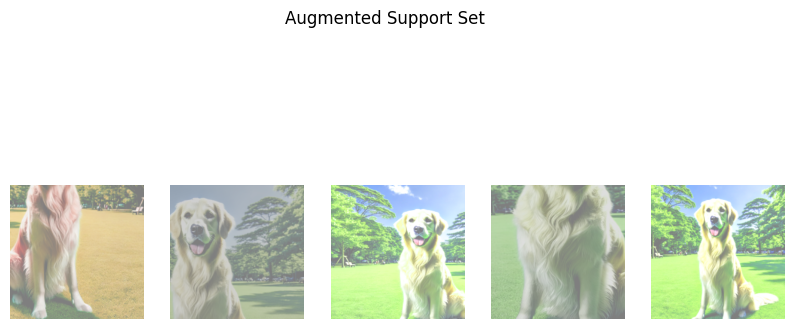

Query Images:


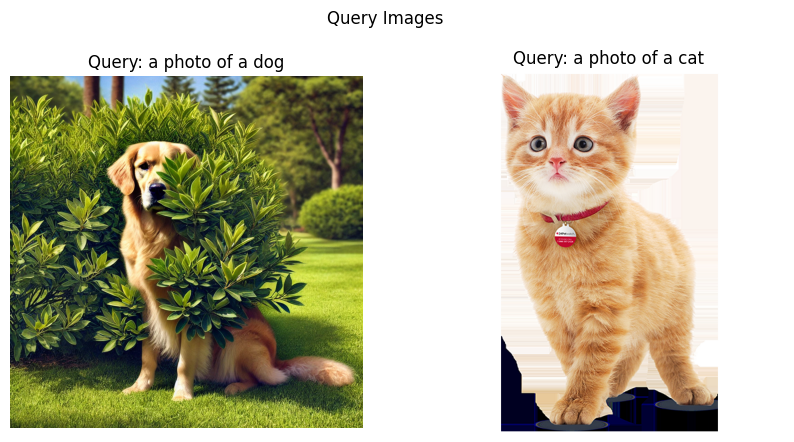


Predictions for each query image:
Query Image 1:
  Ground Truth: a photo of a dog (0)
  Predicted with Support Set: a photo of a dog (1)
  Predicted without Support Set: a photo of a cat (1)
Query Image 2:
  Ground Truth: a photo of a cat (1)
  Predicted with Support Set: a photo of a dog (0)
  Predicted without Support Set: a photo of a cat (1)

Metrics with Support Set:
Accuracy: 0.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%

Confusion Matrix:
[[0 1]
 [1 0]]

Metrics without Support Set:
Accuracy: 50.00%
Precision: 25.00%
Recall: 50.00%
F1-Score: 33.33%

Confusion Matrix:
[[0 1]
 [0 1]]
Calculating Prototypes for Support Set...
Prototype-Based Few-Shot Metrics:
Accuracy: 50.00%
Precision: 25.00%
Recall: 50.00%
F1-Score: 33.33%

Confusion Matrix:
[[1 0]
 [1 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
if __name__ == "__main__":
    # Support 이미지 및 텍스트 준비
    support_image_path = "dog.jpg"
    support_text = "a photo of a dog"
    support_images = augment_support_set(support_image_path, num_variations=5)
    support_texts = [support_text] * len(support_images)

    # Query 이미지 및 레이블 준비
    query_image_paths = ["query_dog.jpg", "query_cat.jpg"]
    query_texts = ["a photo of a dog", "a photo of a cat"]
    query_images = [Image.open(path).convert("RGB") for path in query_image_paths]
    query_labels = [0, 1]  # 0: Dog, 1: Cat

    # Support Set 시각화
    print("Augmented Support Set:")
    plt.figure(figsize=(10, 5))
    for i, img_tensor in enumerate(support_images):
        img = img_tensor.permute(1, 2, 0).numpy()  # Tensor를 이미지로 변환
        img = (img * 0.5 + 0.5).clip(0, 1)  # 정규화 해제
        plt.subplot(1, len(support_images), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle("Augmented Support Set")
    plt.show()

    # Query 이미지 시각화
    print("Query Images:")
    plt.figure(figsize=(10, 5))
    for i, query_image in enumerate(query_images):
        plt.subplot(1, len(query_images), i + 1)
        plt.imshow(query_image)
        plt.title(f"Query: {query_texts[i]}")
        plt.axis("off")
    plt.suptitle("Query Images")
    plt.show()

    # Few-Shot 학습
    predictions_with_support = []
    predictions_without_support = []

    print("\nPredictions for each query image:")
    for i, (query_image, query_label) in enumerate(zip(query_images, query_labels)):
        # Query 이미지 하나와 레이블 하나만 전달
        pred_with_support = few_shot_learning(support_images, support_texts, [query_image], [query_label])
        pred_without_support = few_shot_learning([], query_texts, [query_image], [query_label])

        predictions_with_support.append(pred_with_support)
        predictions_without_support.append(pred_without_support)

        # 예측 결과 출력
        print(f"Query Image {i + 1}:")
        print(f"  Ground Truth: {query_texts[query_label]} ({query_label})")
        print(f"  Predicted with Support Set: {support_texts[int(pred_with_support)]} ({int(pred_with_support)})")
        print(f"  Predicted without Support Set: {query_texts[int(pred_without_support)]} ({int(pred_without_support)})")

    # 결과 출력
    print("\nMetrics with Support Set:")
    calculate_metrics(query_labels, predictions_with_support, ["dog", "cat"])

    print("\nMetrics without Support Set:")
    calculate_metrics(query_labels, predictions_without_support, ["dog", "cat"])

    # Prototype 기반 학습
    print("Calculating Prototypes for Support Set...")
    # Prototype 기반 학습
    support_labels = [0] * len(support_images)  # 모든 Support 이미지는 Dog 클래스
    prototypes = calculate_prototypes(support_images, support_labels)

    predictions = []
    for query_image, query_label in zip(query_images, query_labels):
        pred_label = few_shot_with_prototypes(prototypes, query_image, query_label)
        predictions.append(pred_label)

    # 성능 평가
    print("Prototype-Based Few-Shot Metrics:")
    calculate_metrics(query_labels, predictions, ["dog", "cat"])


In [20]:
if __name__ == "__main__":
    # Prototype 기반 학습
    support_labels = [0] * len(support_images)  # 모든 Support 이미지는 Dog 클래스
    prototypes = calculate_prototypes(support_images, support_labels)

    predictions = []
    for query_image, query_label in zip(query_images, query_labels):
        pred_label = few_shot_with_prototypes(prototypes, query_image, query_label)
        predictions.append(pred_label)

    # 성능 평가
    print("Prototype-Based Few-Shot Metrics:")
    calculate_metrics(query_labels, predictions, ["dog", "cat"])

Prototype-Based Few-Shot Metrics:
Accuracy: 50.00%
Precision: 25.00%
Recall: 50.00%
F1-Score: 33.33%

Confusion Matrix:
[[1 0]
 [1 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
